* This Notebook Contains All The components of Transformer Block Step by Step
in GPT-2 Model this Transformer Block is stacked 12 Times along with other other components which gives "Logit Matrix" as Output which has embdim of vocab size that is 50257 these are the probability of next token and the token with highest probability is choosen as a next token/word.

# PART 1 ) IMPLIMENTATION OF GPT MODEL (gpt-2)

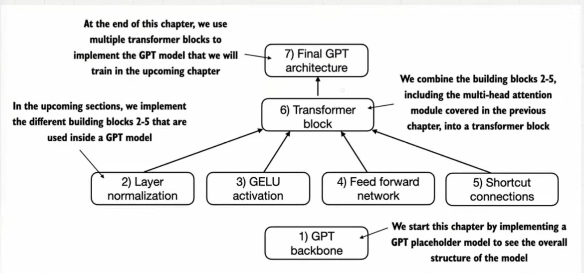

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":1024,
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}

In [3]:
import torch
import torch.nn as nn
import importlib
import tiktoken

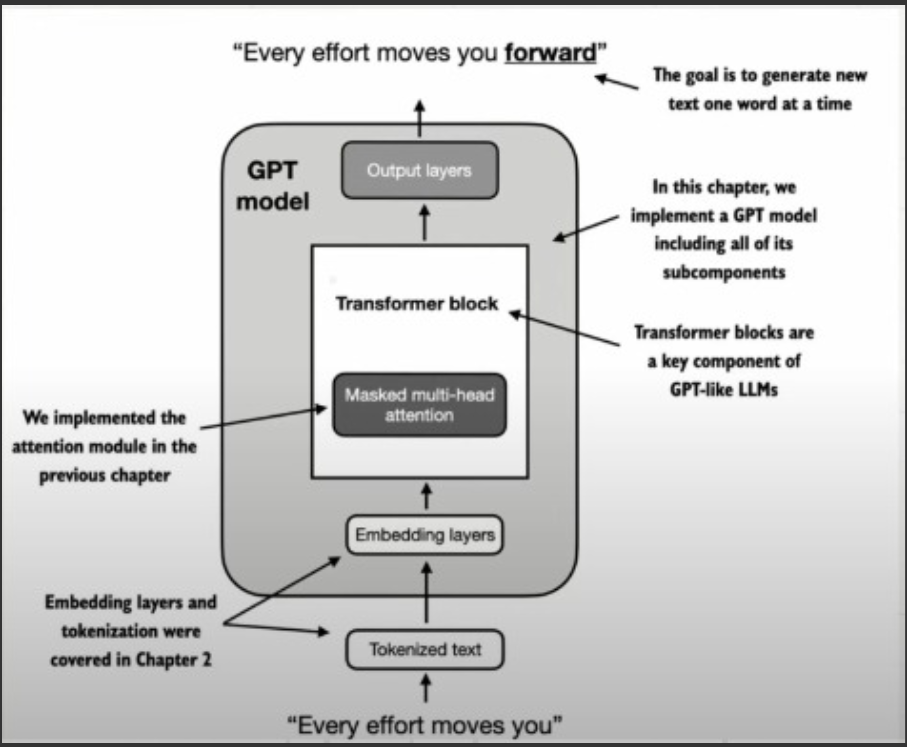

# Inside Transformer Block
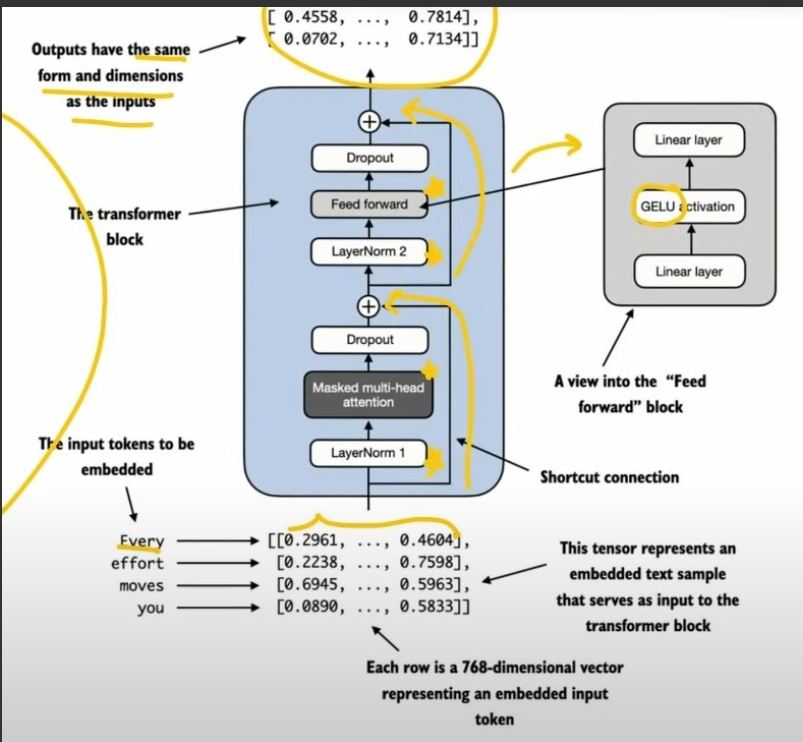

In [4]:
class dummyGptModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) #(50257x768)
    self.positionEmbedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbedding = nn.Dropout(cfg["drop_rate"])

    # PlaceHolder for TransformerBlock
    self.transformerBlock = nn.Sequential(
    *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )


    # PlaceHolder for LayerNorm
    self.finalNormalization = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbedding(inIdx)
    positionEmbeddings = self.positionEmbedding(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionEmbeddings
    x = self.dropuoutEmbedding(x)
    x = self.transformerBlock(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x
class DummyLayerNorm(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = dummyGptModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits)
print(logits.shape)

tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


Above The output tensor has two rows coresponding to the two text samples. Each text sample consists of 4 tokens, each token is 50,257 dimensional vector which is equivalent to vocab size, this means in each iteration each token has
50,257 probabilities for next token and the token with highest probability is choosen as a next token in each iteration

# PART 2) LAYER NORMALIZATION
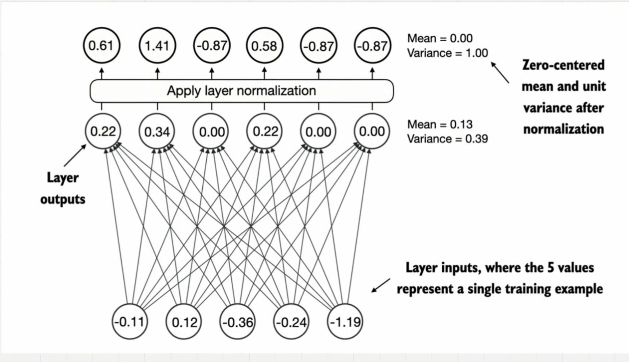

In [7]:
# Simple Example of Layer Normalization
torch.manual_seed(123)
batchExample = torch.randn(2, 5)  # 2 rows(Batches), 5 Columns
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batchExample)
print(out)

mean = out.mean(dim =-1, keepdim= True) # Mean Along Column
var = out.var(dim =-1, keepdim= True) # Variance Along Column
print("Mean Before Normalization:\n" ,mean)
print("Variance Before Normalization:\n", var)

normalizedOutput = (out-mean)/torch.sqrt(var)
meanAfter = normalizedOutput.mean(dim =-1, keepdim= True) # Mean Along Column
varAfter = normalizedOutput.var(dim =-1, keepdim= True) # Variance Along Column
print("Mean After Normalization:\n" ,meanAfter)
print("Variance After Normalization:\n", varAfter)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean Before Normalization:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance Before Normalization:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Mean After Normalization:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance After Normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task


In [9]:
layerNormalization = LayerNorm(emb_dim=5)
layerNormalizationOutput = layerNormalization(batchExample)
mean = layerNormalizationOutput.mean(dim =-1, keepdim= True) # Mean Along Column
var = layerNormalizationOutput.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Columnprint(layerNormalizationOutput)
print(batchExample)
print(layerNormalizationOutput)
print("Mean After Normalization:\n" ,mean)
print("Variance After Normalization:\n", var)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Mean After Normalization:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance After Normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# PART 3 ) GELU ACTIVATION FUNCTION

In [10]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

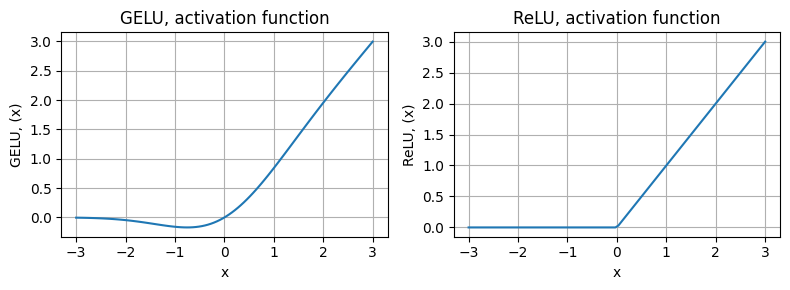

In [11]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
yGelu, yRelu = gelu(x), relu(x)
plt.figure(figsize = (8,3))
for i, (y, label) in enumerate(zip([yGelu, yRelu], ["GELU", "ReLU"]),1):
  plt.subplot(1,2,i)
  plt.plot(x, y)
  plt.title(f"{label}, activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}, (x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

# PART 4) FEED FORWARD NEURAL NETWORK
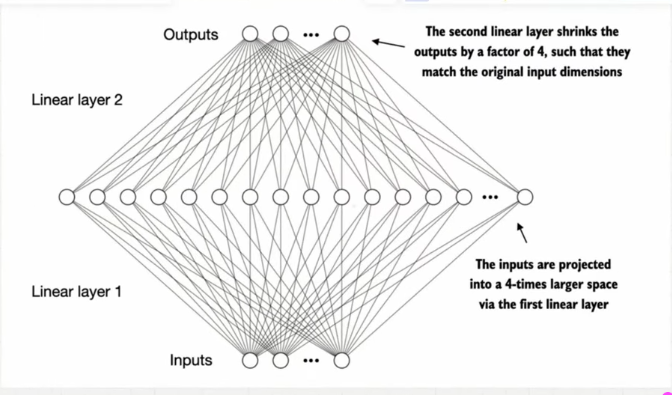

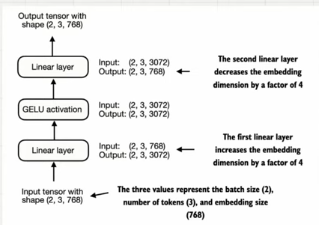

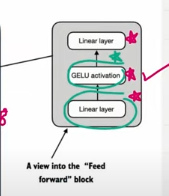

In [12]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [13]:
ffnn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
outPut = ffnn(x)

print(outPut)
print(outPut.shape)

tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1051,  ...,  0.1438,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0702,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 768])


# PART 5) SHORTCUT CONNECTIONS
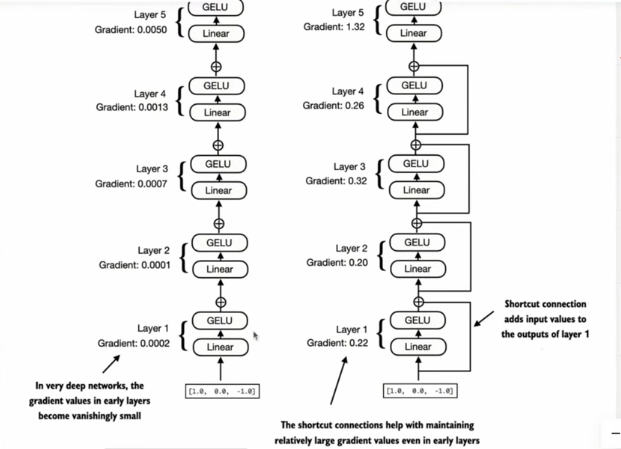










In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [15]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [16]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [17]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [18]:
modelWithShortcut = ExampleDeepNeuralNetwork(layer_sizes, True)
print(print_gradients(modelWithShortcut, sample_input))

layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846952389925718
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115121752024
layers.4.0.weight has gradient mean of 0.032659437507390976
None


# PART 6 ) TRANSFORMER BLOCK


In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

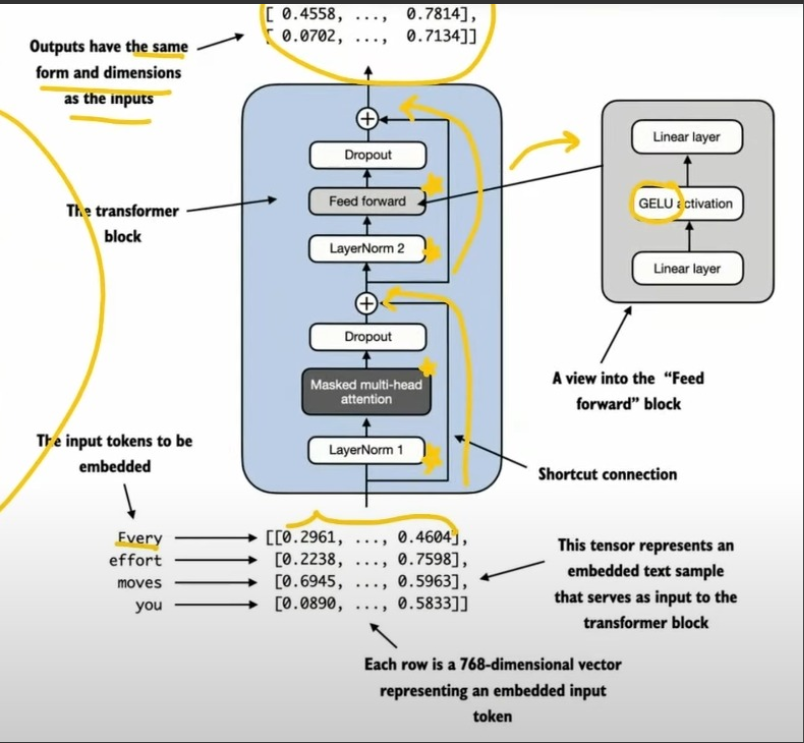

In [31]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [32]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
tfb = TransformerBlock(GPT_CONFIG_124M)
output = tfb(x)
print(x)
print(x.shape)
print(output)
print(output.shape)


tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
torch.Size([2, 4, 768])
tensor([[[-0.0056,  0.0971, -0.1123,  ...,  1.2889,  0.2623,  0.6686],
         [ 0.0023, -0.2369,  0.1719,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2526,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7427,  0.7016]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1853,  0.0112, -0.5035],
         [-0.0225,  0.7790,  0.2769,  ...,  0.1734,  0.5419,  0.1143],
         [ 0.7425,  0.40